# Multiple Logistic Regression

Logistic regression is named for the function used at the core of the method, the logistic function. However, despite its name it is a linear model for classification rather than regression.

Logistic regression uses an equation as the representation, very much like linear regression. Input values (X) are combined linearly using weights or coefficient values to predict an output value (y). A key difference from linear regression is that the output value being modeled is a binary value (0 or 1) rather than a numeric one. We're not going to deal here with Multiclass Logistic Regression which can classify the output into more than 2 classes but feel free to read about the [One vs All](http://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest) approach to it. Basically, it's possible to solve that problem by decomposing it into binary classification problems.

Each column in your input data has an associated b coefficient (a constant real value) that must be learned from your training data. The actual representation of the model that you would store in memory or in a file are the coefficients in the equation (the beta value or b’s). For this assignment, the coefficients of the logistic regression algorithm must be estimated from your training data using **gradient descent**.

Gradient Descent is the process of minimizing a function by following the gradients of the cost function. This involves knowing the form of the cost as well as the derivative so that from a given point you know the gradient and can move in that direction, e.g. downhill towards the minimum value.

## Exercise 1 - Explore the Data

After we develop our logistic regression algorithm with stochastic gradient descent, we will use it to model the Pima Indians diabetes dataset. This dataset involves predicting the onset of diabetes within 5 years in Pima Indians given basic medical details. It is a binary classification problem, where the prediction is either 0 (no diabetes) or 1 (diabetes). It contains 768 rows and 9 columns. All of the values in the file are numeric, specifically floating point values. You can learn more about the dataset on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes).

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

pima = pd.read_csv('pima-indians-diabetes.data', header=None)
pima.head()


,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
pima.columns = ['pregnant', 'glucose', 'diastolic', 'triceps', 'insulin', 'bmi', 'diabetes', 'age', 'class']

In [4]:
pima.describe()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
pima.dtypes

pregnant       int64
glucose        int64
diastolic      int64
triceps        int64
insulin        int64
bmi          float64
diabetes     float64
age            int64
class          int64
dtype: object

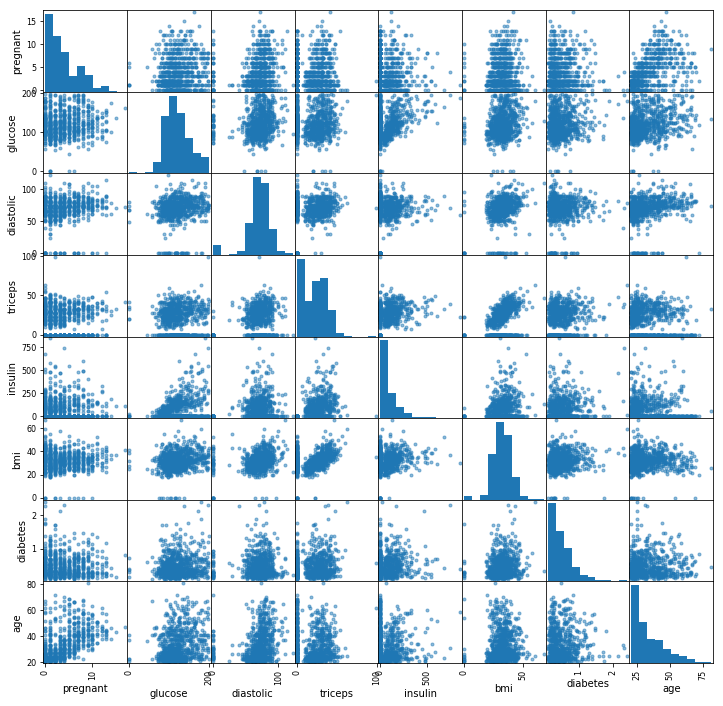

In [11]:
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

features = pima.drop('class', axis=1)
scatter_matrix(features, figsize=(12,12)); # semicolon removes the output above scattermatrix

From the webpage regarding missing values: "Until 02/28/2011 this web page indicated that there were no missing values in the dataset. As pointed out by a repository user, this cannot be true: there are zeros in places where they are biologically impossible, such as the blood pressure attribute. It seems very likely that zero values encode missing data. However, since the dataset donors made no such statement we encourage you to use your best judgement and state your assumptions." We will leave values as is and not manipulate the data too much.

In [24]:
corr = pima.corr()
corr

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,class
pregnant,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
diastolic,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
triceps,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
diabetes,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
class,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


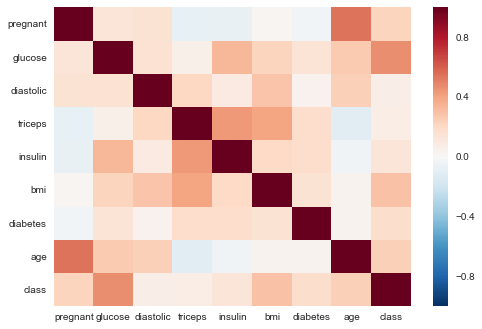

In [23]:
import seaborn as sns

sns.heatmap(corr)

## Exercise 2 - Build a Multiple Logistic Regression Class

The general steps are:
- Estimate coefficient values for the training data using gradient descent
- Evaluate candidate coeffeicient values 
- Tune learning rate and number of epochs
- Make predictions on out-of-sample data

The class should do the following:
- Fit a set of X (health data) and y (diabetes binary value)
- Return the intercept and coefficients
- Predict test samples based on the coefficients (either class 0 or 1)
- Return accuracy score
- Optional: return the probability estimates for each class

In [56]:
from numpy import matlib

class log_reg:
    
    def __init__(self, x, y):
        self.x = self._add_intercept(x)
        self.y = y
        
    def _add_intercept(self, x):
        x_intercept = matlib.ones((len(x), 1))
        return np.hstack((x_intercept, x)) # stack ones to left of matrix
    
    def _sigmoid(self, x, coef): # inverse of logistic function
        z = x * coef
        return 1 / (1 + np.exp(-z))
    
    def _compute_cost(self, yhat):
        temp1 = np.log(yhat).T * self.y
        temp2 = np.log(1 - yhat).T * (1 - self.y)
        return -np.sum(temp1 + temp2) / len(self.x) # cost function
        
    def _compute_gradient(self, yhat):
        error = yhat - self.y
        summation = self.x.T * error
        return summation / len(self.x)
    
    def _gradient_descent(self, learning_rate, epochs):
        coef = matlib.zeros(self.x.shape[1]).T #initialize
        cost = np.zeros(epochs) #initialize
        
        for i in range(epochs):
            yhat = self._sigmoid(self.x, coef)
            temp_coef = coef - learning_rate * self._compute_gradient(yhat)
            coef = temp_coef
            cost[i] =  self._compute_cost(yhat)
            
        return coef, cost
    
    def fit(self, learning_rate=0.01, epochs=1000): # learning rate is how fast to learn and epochs are iterations
        self.coef, self.cost = self._gradient_descent(learning_rate, epochs)
        
    def predict_prob(self, x): # probability class = 1
        try: # need this because it will throw an error if we call before fit
            prob_1 = self._sigmoid(self._add_intercept(x), self.coef)
            prob_0 = 1 - prob_1
            return np.column_stack((prob_0, prob_1))
        
        except AttributeError:
            raise RuntimeError("This {} instance is not fitted yet.".format(self.__class__.__name__)
                               + "Call 'fit' before using this method.") 
                                
    def predict(self, x):
        prob = self.predict_prob(x)[:,1] # prediction estimates for class 1
        predictions = prob >= 0.5 # boolen but want 0 or 1, this is where the sigmoid crosses 0.5
        return np.matrix(predictions, dtype=int)
    
    def score(self, x, y):
        predicted = self.predict(x)
        return np.average(y == predicted) * 100

## Exercise 3 - Try it out on the Pima Indians Diabetes Data Set

In [57]:
from sklearn.preprocessing import scale

scaled_features = scale(pima.iloc[:, :-1])
features = np.asmatrix(scaled_features)
y = np.asmatrix(pima['class']).T

n_train = len(y) * 7 // 10
train = features[:n_train]
ytrain = y[:n_train]
test = features[n_train:]
ytest = y[n_train:]

In [58]:
model = log_reg(train, ytrain)

cost_by_learning_rate = pd.DataFrame()
for learning_rate in [0.01, 0.03, 0.1, 0.3, 1, 3]:
    model.fit(learning_rate=learning_rate, epochs=200)
    cost_by_learning_rate[learning_rate] = model.cost

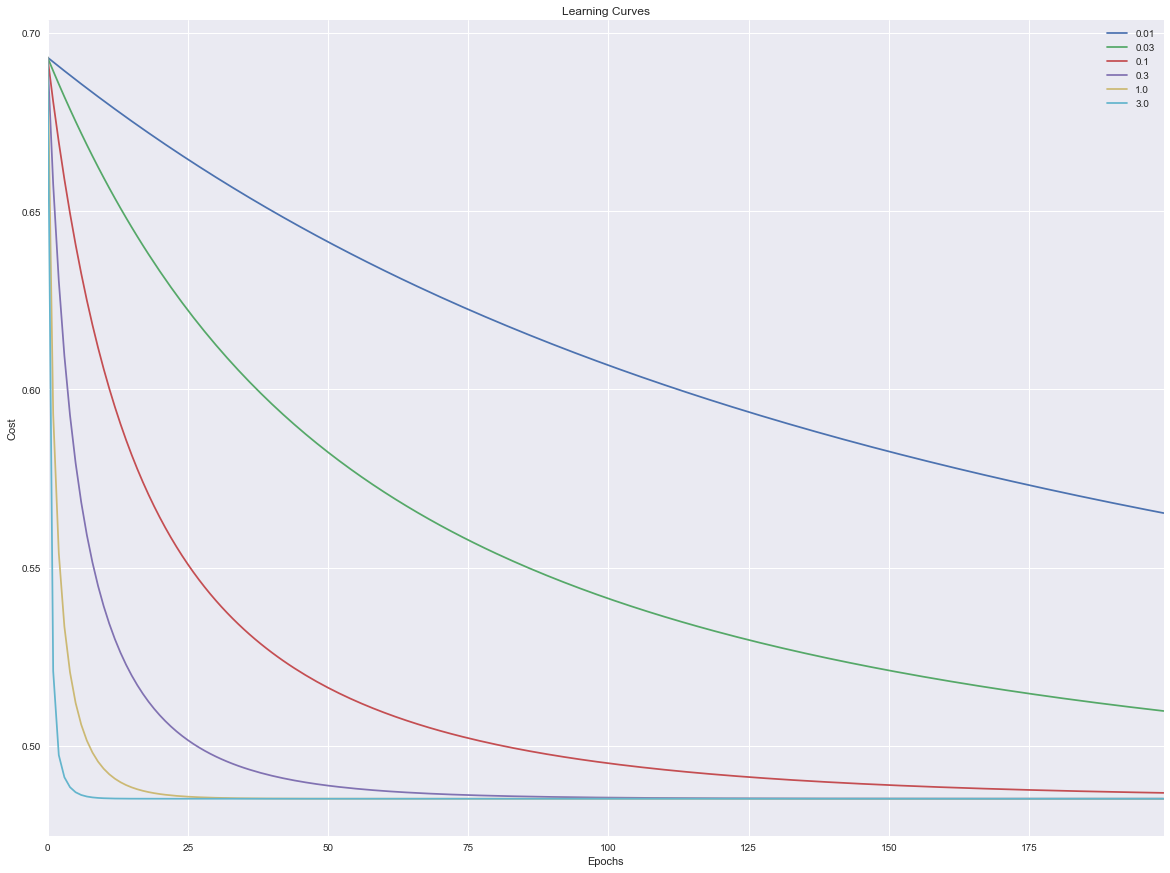

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,15))
cost_by_learning_rate.plot(title='Learning Curves', ax=ax)
ax.set_xlabel('Epochs')
ax.set_ylabel('Cost')

In [60]:
model.fit(learning_rate=3, epochs=60)
print(model.cost[-6])
print(model.cost[-1])

0.485152450693
0.485152450691


In [61]:
model.coef

matrix([[-0.82907251],
        [ 0.42381326],
        [ 1.01085402],
        [-0.20756213],
        [ 0.02024768],
        [-0.14902716],
        [ 0.73172129],
        [ 0.30405959],
        [ 0.06757616]])

In [62]:
model.predict(test)[:15]

matrix([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0]])

In [63]:
model.score(test, ytest)

79.220779220779221

In [66]:
baseline = 1 - np.average(ytest)
baseline * 100

65.800865800865793

In [67]:
model.predict_prob(test)[:15]

matrix([[ 0.97538972,  0.02461028],
        [ 0.67659902,  0.32340098],
        [ 0.53197032,  0.46802968],
        [ 0.56272124,  0.43727876],
        [ 0.69122413,  0.30877587],
        [ 0.58889949,  0.41110051],
        [ 0.85870407,  0.14129593],
        [ 0.91904498,  0.08095502],
        [ 0.17229304,  0.82770696],
        [ 0.05289645,  0.94710355],
        [ 0.69053911,  0.30946089],
        [ 0.46643342,  0.53356658],
        [ 0.28675813,  0.71324187],
        [ 0.87886626,  0.12113374],
        [ 0.88688079,  0.11311921]])

## Exercise 4 - Check via Statsmodels or Scikit-learn

In [69]:
import sklearn.linear_model as linear_model

sk_model = linear_model.LogisticRegression()
sk_model.fit(train, np.ravel(ytrain))

print(sk_model.intercept_)
print(sk_model.coef_)

[-0.81333548]
[[ 0.41469573  0.98899874 -0.20098739  0.01837945 -0.13987807  0.71579307
   0.29809781  0.07104457]]


In [70]:
model.coef

matrix([[-0.82907251],
        [ 0.42381326],
        [ 1.01085402],
        [-0.20756213],
        [ 0.02024768],
        [-0.14902716],
        [ 0.73172129],
        [ 0.30405959],
        [ 0.06757616]])

In [71]:
sk_model.predict(test)[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0])

In [72]:
model.predict(test)[:15]

matrix([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0]])

In [73]:
sk_model.score(test, ytest)

0.79220779220779225

In [74]:
sk_model.predict_proba(test[:15])

array([[ 0.97316419,  0.02683581],
       [ 0.67300489,  0.32699511],
       [ 0.53080196,  0.46919804],
       [ 0.55942067,  0.44057933],
       [ 0.68729911,  0.31270089],
       [ 0.58589306,  0.41410694],
       [ 0.85459033,  0.14540967],
       [ 0.91537574,  0.08462426],
       [ 0.17605909,  0.82394091],
       [ 0.05538855,  0.94461145],
       [ 0.68696921,  0.31303079],
       [ 0.46634396,  0.53365604],
       [ 0.29097129,  0.70902871],
       [ 0.87559532,  0.12440468],
       [ 0.88286036,  0.11713964]])

In [75]:
model.predict_prob(test)[:15]

matrix([[ 0.97538972,  0.02461028],
        [ 0.67659902,  0.32340098],
        [ 0.53197032,  0.46802968],
        [ 0.56272124,  0.43727876],
        [ 0.69122413,  0.30877587],
        [ 0.58889949,  0.41110051],
        [ 0.85870407,  0.14129593],
        [ 0.91904498,  0.08095502],
        [ 0.17229304,  0.82770696],
        [ 0.05289645,  0.94710355],
        [ 0.69053911,  0.30946089],
        [ 0.46643342,  0.53356658],
        [ 0.28675813,  0.71324187],
        [ 0.87886626,  0.12113374],
        [ 0.88688079,  0.11311921]])

# Additional Optional Exercises

- Proper documentation for class methods and attributes.
- If you're into healthcare data, figure out if you can do some feature engineering in order to increase the accuracy. And maybe even doing some research about additional metrics that could be useful, like precision, recall and F1-score.
- Read about how to model a Multiclass Classification problem by decomposing it into binary classification problems with the [One vs All](http://scikit-learn.org/stable/modules/multiclass.html#one-vs-the-rest) approach. Try it out on the Iris dataset.
- Try re-writing the code with NumPy's more usual `ndarray`s.
- Add an optional parameter to stop iterating if it has already converged or if it is diverging (tip: try to use relative values instead of absolute ones).
- Try to write code that dinamically chooses an optimal learning rate given the data at hand.
- Change from batch gradient descent to either [stochastic or mini-batch gradient descent](http://sebastianruder.com/optimizing-gradient-descent). 
- [Other varieties](https://tminka.github.io/papers/logreg/index.html) of logistic regression.